<a href="https://colab.research.google.com/github/shebogholo/pytorch/blob/master/Convolutional%20Neural%20Network%2001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import libraries

In [0]:
import os
import glob
import torch
import numpy as np
import torchvision
from PIL import Image
import torch.nn as nn
import os.path as path
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

## Hyperparameters

In [0]:
seed = 123
num_epochs = 30
batch_size = 32
valid_size = 0.1
num_workers = 1
log_interval = 1000
learning_rate = 0.001
checkpoint_path = 'model.pth'

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Custom Dataset

In [0]:
# Download MNIST png data
!wget -q https://github.com/myleott/mnist_png/blob/master/mnist_png.tar.gz?raw=true
!mv mnist_png.tar.gz?raw=true mnist_png.tar.gz
!tar -xzf mnist_png.tar.gz

In [0]:
# Define custom dataset class
class MNIST(Dataset):
  def __init__(self, root, transform=None):
    self.images = None
    self.labels = None
    self.root = root
    self.transform = transform
    self.filenames = []

    # read filenames
    for label in range(10):
      filenames = glob.glob(os.path.join(root, str(label), '*.png'))
      for filename in filenames:
        self.filenames.append((filename, label))

  def __getitem__(self, index):
    # load data from image list
    image, label = self.filenames[index]
    image = Image.open(image)

    if self.transform is not None:
      image = self.transform(image)
    # return image and label
    return image, label
  
  # total number of samples in the dataset
  def __len__(self):
    return len(self.filenames)

In [5]:
'''
Create instances of Custom dataset class for training and test data 
Convert all the images to Tensor (Transformation)
'''
train_data = MNIST(root='mnist_png/training', transform=transform.ToTensor())
test_data  = MNIST(root='mnist_png/testing', transform=transform.ToTensor())
print(len(train_data))
print(len(test_data))

60000
10000


## Split data

In [0]:
def split_data(train_data, test_data=None, batch_size=20, valid_size=.1, sampler = SubsetRandomSampler):
  num_train = len(train_data)
  indices = list(range(num_train))
  np.random.shuffle(indices)
  split = int(np.floor(valid_size * num_train))
  train_idx, valid_idx = indices[split:], indices[:split]
  train_sampler = sampler(train_idx)
  valid_sampler = sampler(valid_idx)
  if test_data is not None:
    test_loader = DataLoader(test_data, batch_size, num_workers)

  else :
    train_idx, test_idx = train_idx[split:], train_idx[:split]
    train_sampler = sampler(train_idx)
    test_sampler  = sampler(test_idx)
    test_loader = DataLoader(test_data, batch_size, test_sampler, num_workers, shuffle=False)

  train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, sampler=train_sampler, num_workers=num_workers)
  valid_loader = DataLoader(train_data, batch_size=batch_size, shuffle=False, sampler=valid_sampler, num_workers=num_workers)
  return train_loader, valid_loader, test_loader

## Data Loaders

In [7]:
train_loader, valid_loader, test_loader = split_data(train_data, test_data, batch_size)
len(train_loader), len(valid_loader), len(test_loader)

(1688, 188, 313)

## Visualize dataset

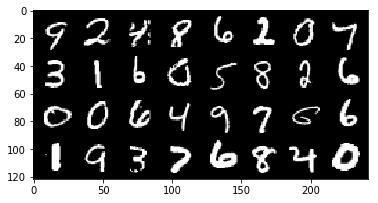

In [8]:
# function to show an image
def show_image(image):
  image = image.numpy()
  plt.imshow(np.transpose(image, (1, 2, 0)))

# get random training images
images, labels = next(iter(test_loader))
show_image(torchvision.utils.make_grid(images))

In [9]:
# check the available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Define a CNN

In [0]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        # Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        
        # Linear(in_features, out_features, bias=True)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
        # MaxPool2d(kernel_size, stride=None, padding=0, dilation=1, return_indices=False, ceil_mode=False)
        self.max_pool = nn.MaxPool2d(2)
        # ReLU(inplace=False)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.max_pool(self.conv1(x)))
        x = self.relu(self.max_pool(self.conv2(x)))
        x = x.view(-1, 320)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Network().to(device)

## Define Optimizer

In [0]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

## Define Loss function

In [0]:
criterion = nn.NLLLoss()

## Function to train a model

In [0]:
def train(train_loader, epoch, log_interval):
  for batch_idx, (data, target) in enumerate(train_loader):
    # bring data to the computing device, e.g. GPU
    data, target = data.to(device), target.to(device)
    # forward pass
    output = model(data)
    # compute loss: negative log-likelihood
    loss = criterion(output, target)
    # backward pass
    # clear the gradients of all tensors being optimized.
    optimizer.zero_grad()
    # accumulate (i.e. add) the gradients from this forward pass
    loss.backward()
    # performs a single optimization step (parameter update)
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Epoch: {} \tloss: {:.6f}'.format(epoch+1, loss.item()))
  return model

## Function to validate a model

In [0]:
def evaluate(model, valid_loader):
  model.eval()  
  valid_loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad():
    for _, (data, target) in enumerate(valid_loader):
      data, target = data.to(device), target.to(device)
      output = model(data)
      loss = criterion(output, target) # sum up batch loss
      total += len(target)
      predicted = torch.max(output.data, 1)[1]
      correct += (target == predicted).sum() 
      valid_loss += loss.item() * data.size(0)
  valid_loss = valid_loss / len(valid_loader.dataset)
  valid_accuracy = 100. * correct / float(total)
  print('\nValidation loss: {:.4f}, accuracy: {:.0f}%'.format(valid_loss, valid_accuracy))
  return valid_loss, valid_accuracy

## Function to save a model

In [0]:
def save_checkpoint(checkpoint_path, model, optimizer, best_score):
  state = {
      'state_dict': model.state_dict(),
      'optimizer' : optimizer.state_dict(),
      'accuracy': best_score}
  torch.save(state, checkpoint_path)
  print('Saved a model with best score of {:.2f} to \'{}\'\n'.format(best_score, checkpoint_path))

## Train and save best model

In [16]:
def fit(num_epochs, train_loader, valid_loader, log_interval):
  best_score = 0.0
  for epoch in range(num_epochs):
    model = train(train_loader, epoch, log_interval)
    _, accuracy = evaluate(model, valid_loader)
    if accuracy > best_score:
      best_score = accuracy
      save_checkpoint(checkpoint_path, model, optimizer, best_score)

fit(num_epochs, train_loader, valid_loader, log_interval)

Epoch: 1 	loss: 2.286008
Epoch: 1 	loss: 0.524164

Validation loss: 0.0294, accuracy: 91%
Saved a model with best score of 91.00 to 'model.pth'

Epoch: 2 	loss: 0.159661
Epoch: 2 	loss: 0.075388

Validation loss: 0.0173, accuracy: 94%
Saved a model with best score of 94.00 to 'model.pth'

Epoch: 3 	loss: 0.224553
Epoch: 3 	loss: 0.178041

Validation loss: 0.0133, accuracy: 96%
Saved a model with best score of 96.00 to 'model.pth'

Epoch: 4 	loss: 0.390398
Epoch: 4 	loss: 0.279257

Validation loss: 0.0133, accuracy: 96%
Epoch: 5 	loss: 0.050137
Epoch: 5 	loss: 0.118696

Validation loss: 0.0099, accuracy: 97%
Saved a model with best score of 97.00 to 'model.pth'

Epoch: 6 	loss: 0.072231
Epoch: 6 	loss: 0.133394

Validation loss: 0.0095, accuracy: 97%
Epoch: 7 	loss: 0.055815
Epoch: 7 	loss: 0.169539

Validation loss: 0.0092, accuracy: 97%
Epoch: 8 	loss: 0.161822
Epoch: 8 	loss: 0.051747

Validation loss: 0.0091, accuracy: 97%
Epoch: 9 	loss: 0.029346
Epoch: 9 	loss: 0.082588

Validatio

## Load model

In [17]:
def load_checkpoint(checkpoint_path):
    state = torch.load(checkpoint_path)
    model.load_state_dict(state['state_dict'])
    accuracy = state['accuracy']
    print('Loaded a model with accuracy of {:.1f}% from {}'.format(accuracy, checkpoint_path))
    return model

loaded_model = load_checkpoint(checkpoint_path)

Loaded a model with accuracy of 98.0% from model.pth


## Test loaded model

In [18]:
loaded_model.eval()
test_loss = 0
total = 0
correct = 0
with torch.no_grad():
  for _, (data, target) in enumerate(test_loader):
    data, target = data.to(device), target.to(device)
    output = loaded_model(data)
    test_loss += criterion(output, target).item()
    pred = output.max(1, keepdim=True)[1]
    total += target.size(0)
    correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(test_loader.dataset)
  test_accuracy = 100. * correct / total
  print('\nTest loss: {:.4f}, accuracy: {}/{} ({:.0f}%)'.format(test_loss, correct, total, test_accuracy))


Test loss: 0.0014, accuracy: 9848/10000 (98%)


## Inference

In [0]:
def predict(inputs, topk=1):
  model.eval()
  model.to(device)
  with torch.no_grad():
    inputs = inputs.to(device)
    outputs = model(inputs)
    prediction = torch.exp(outputs)
    prob, top = prediction.topk(topk, dim=1)
    # pred = prediction.max(1, keepdim=True)[1].item()
    # print(pred)
  return prob, top

## Upload image

In [0]:
transfomer = transform.Compose([transform.Resize([28,28]),transform.ToTensor()])

In [0]:
def load_image(image_path):
  # read and convert the image into grayscale
  image = Image.open(image_path).convert('L')
  # tansform the image, resize, crop, convert to tensor
  image = transfomer(image).float()
  # return tensor image with fake batch_size of 1
  return image.unsqueeze_(0)

In [22]:
''' Set path to your input image
    Note: Image should have black background'''

image_path = '/content/1.jpg'
image = load_image(image_path)
image.shape

torch.Size([1, 1, 28, 28])

In [23]:
prob, top = predict(load_image(image_path))
print('Prediction: ', top.item())
print('Accuracy:    {:.0f}%'.format(prob.item()*100))

Prediction:  1
Accuracy:    86%
